In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit
from uniform_encoders import *

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
# sns.set(context='paper', style='white', font='CMU Serif')
sns.set(context='paper', style='white', font='CMU Serif', rc={'font.size':10, 'mathtext.fontset': 'cm'})

In [2]:
class Inputs():
    def __init__(self, nCS=1, nCTX=2, dim_CS=3, dim_CTX=2, seed=0):
        self.rng = np.random.RandomState(seed=seed)
        self.sampler = ScatteredHypersphere(surface=True)
        self.dim_CS = dim_CS
        self.dim_CTX = dim_CTX
        self.nCS = nCS
        self.nCTX = nCTX
        self.CS = np.zeros((self.dim_CS))
        self.US = 0
        self.CTX = np.zeros((self.dim_CTX))
        self.CSs = self.sampler.sample(nCS, dim_CS, rng=self.rng)
        self.CTXs = self.sampler.sample(nCTX, dim_CTX, rng=self.rng)
        self.stop_learning = 0  # control signal to turn learning off
        self.applied_current = 0  # for experiments with external perturbation
    def get_CS(self, t):
        applied = True if t%2>1 else False  # 1s of no input, 1s of CS input
        return self.CS if applied else np.zeros((self.dim_CS))
    def get_CTX(self, t):
        return self.CTX
    def get_US(self, t):
        applied = True if t%2>1.5 else False # 1.5s of no input, 0.5s of US input 
        return self.US if applied else 0
    def get_stop_learning(self, t):
        return self.stop_learning
    def get_applied_current(self, t):
        return self.applied_current
    
def sparsity_to_x_intercept(d, p):
    sign = 1
    if p > 0.5:
        p = 1.0 - p
        sign = -1
    return sign * np.sqrt(1-scipy.special.betaincinv((d-1)/2.0, 0.5, 2*p))

In [3]:
def build_network(
        dt = 0.001,
        nCond = 5,
        nExt = 10,
        seed = 0,
        nNeurons = 100,
        nNeuronsExtCS = 300,
        nNeuronsExtCTX = 500,
        dim_CS = 3,
        dim_CTX = 5,
        nCS = 1,
        nCTX = 3,
        intercept_CS = 0,
        intercept_CTX = 0,
        intercept_LA_pyr = -0.2,
        lr1 = 3e-5,
        lr2 = 3e-4,
        lr3 = 1e-5,
        T_BLA_CS=0.25,
        T_BLA_CTX=0.75,
        T_BLA_US=1.0,
    ):

    rng = np.random.RandomState(seed=seed)
    sampler = ScatteredHypersphere(surface=True)
    inputs = Inputs(dim_CS=dim_CS, dim_CTX=dim_CTX, nCS=nCS, nCTX=nCTX, seed=seed)
    encoders_LA_pyr = sampler.sample(2*nNeurons, 2, rng=rng)
    intercepts_LA_pyr = nengo.dists.Uniform(intercept_LA_pyr, intercept_LA_pyr)
    encoders_CS = sampler.sample(nNeuronsExtCS, dim_CS, rng=rng)
    encoders_CTX = sampler.sample(nNeuronsExtCTX, dim_CTX, rng=rng)
    intercepts_CS = nengo.dists.Uniform(intercept_CS, intercept_CS)
    intercepts_CTX = nengo.dists.Uniform(intercept_CTX, intercept_CTX)
    intercepts_pos = nengo.dists.Uniform(0,1)
    encoders_pos = nengo.dists.Choice([[1]])
    dInh = -3e0*np.ones((nNeurons, 1))

    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.03
    net.config[nengo.Probe].synapse = 0.03

    with net:
        # inputs and outputs
        CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
        US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
        CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
        bias = nengo.Node(lambda t: 0.5)
        stop_learning = nengo.Node(lambda t, x: inputs.get_stop_learning(t), size_in=2)
        applied_current = nengo.Node(lambda t, x: inputs.get_applied_current(t), size_in=2)
        # external ensembles
        external_CS = nengo.Ensemble(nNeuronsExtCS, dim_CS, intercepts=intercepts_CS, encoders=encoders_CS)
        external_US = nengo.Ensemble(nNeurons, 1)
        external_CTX = nengo.Ensemble(nNeuronsExtCTX, dim_CTX, intercepts=intercepts_CTX, encoders=encoders_CTX)
        # amygdala ensembles
        LA_pyr = nengo.Ensemble(2*nNeurons, 2, radius=2, encoders=encoders_LA_pyr, intercepts=intercepts_LA_pyr)  # [CS, US]
        LA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
        CeL_on = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [CS]
        CeL_off = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [bias-CS]
        CeM = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
        BLA_pyr = nengo.Ensemble(3*nNeurons, 3, radius=3)  # [CS, US, CTX]
        BLA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
        # error ensembles
        error_LA = nengo.Ensemble(nNeurons, 1)
        error_CeL = nengo.Ensemble(nNeurons, 1)
        error_BLA_safe = nengo.Ensemble(nNeurons, 1)
        error_BLA_fear = nengo.Ensemble(nNeurons, 1)
        # external connections
        nengo.Connection(CS, external_CS, synapse=None)
        nengo.Connection(US, external_US, synapse=None)
        nengo.Connection(external_CS, LA_inh[0], function=lambda x: np.sum(np.square(x)))  # any CS present
        nengo.Connection(external_US, LA_pyr[1])
        nengo.Connection(bias, CeL_off, transform=1)
        nengo.Connection(bias, CeM)
        nengo.Connection(CTX, external_CTX, synapse=None)
        # internal connections
        nengo.Connection(LA_pyr[1], LA_inh[1])
        nengo.Connection(CeL_on, CeL_off, transform=-1)
        nengo.Connection(CeL_off, CeM, transform=-1)
        nengo.Connection(LA_pyr, BLA_pyr[:2])  # communicate [CS, US]
        nengo.Connection(BLA_pyr[:2], BLA_inh)  # communicate [CS,US]
        nengo.Connection(BLA_pyr[0], CeM, transform=T_BLA_CS)  # CS response added to total fear response
        nengo.Connection(BLA_pyr[1], CeM, transform=T_BLA_US)  # US response added to total fear response
        nengo.Connection(BLA_pyr[2], CeM, transform=T_BLA_CTX)  # CTX response added to total fear response
        # learned connections
        conditioning = nengo.Connection(external_CS, LA_pyr[0], function=lambda x: 0, learning_rule_type=nengo.PES(lr1))
        transmission = nengo.Connection(LA_pyr[0], CeL_on, function=lambda x: 0, learning_rule_type=nengo.PES(lr2))
        extinction = nengo.Connection(external_CTX, BLA_pyr[2], function=lambda x: 0, learning_rule_type=nengo.PES(lr3))
        # error connections
        nengo.Connection(LA_pyr[0], error_LA, transform=-1)  # -CS response
        nengo.Connection(LA_inh[1], error_LA, transform=+1)  # US
        nengo.Connection(LA_pyr[0], error_CeL, transform=+1)  # LA_pyr CS response
        nengo.Connection(CeL_on, error_CeL, transform=-1)  # -CeL_on CS response
        nengo.Connection(BLA_pyr[2], error_BLA_safe)  # CTX response
        nengo.Connection(BLA_pyr[2], error_BLA_fear, transform=-1)  # -CTX response
        nengo.Connection(BLA_inh[0], error_BLA_safe)  # CS response
        nengo.Connection(BLA_inh[1], error_BLA_fear)  # US
        # error gating
        nengo.Connection(LA_inh, error_LA.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS present
        nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: 1-x[0], transform=dInh)  # inhibit by default; release if CS
        nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: x[1], transform=10*dInh, synapse=0.3)  # inhibit by default; release if CS
        nengo.Connection(BLA_inh, error_BLA_fear.neurons, function=lambda x: 1-x[1], transform=0.5*dInh)  # slow learning unless US
        # error updating
        nengo.Connection(error_LA, conditioning.learning_rule, transform=-1)
        nengo.Connection(error_CeL, transmission.learning_rule, transform=-1)
        nengo.Connection(error_BLA_safe, extinction.learning_rule, transform=1)
        nengo.Connection(error_BLA_fear, extinction.learning_rule, transform=-2)
        # stop learning during testing
        nengo.Connection(stop_learning, error_LA.neurons, transform=-1e3*np.ones((nNeurons, 1)))
        nengo.Connection(stop_learning, error_BLA_safe.neurons, transform=-1e3*np.ones((nNeurons, 1)))
        nengo.Connection(stop_learning, error_CeL.neurons, transform=-1e3*np.ones((nNeurons, 1)))
        nengo.Connection(stop_learning, error_BLA_fear.neurons, transform=-1e3*np.ones((nNeurons, 1)))

        # probes
        net.pCS = nengo.Probe(CS, synapse=None)
        net.pUS = nengo.Probe(US, synapse=None)
        net.pCTX = nengo.Probe(CTX, synapse=None)
        net.pLA_pyr_spikes = nengo.Probe(LA_pyr.neurons)
        net.pLA_inh_spikes = nengo.Probe(LA_inh.neurons)
        net.pCeL_on_spikes = nengo.Probe(CeL_on.neurons)
        net.pCeL_off_spikes = nengo.Probe(CeL_off.neurons)
        net.pCeM_spikes = nengo.Probe(CeM.neurons)
        net.pBLA_pyr_spikes = nengo.Probe(BLA_pyr.neurons)
        net.pBLA_inh_spikes = nengo.Probe(BLA_inh.neurons)
        net.pBLA_pyr = nengo.Probe(BLA_pyr)
        net.pBLA_inh = nengo.Probe(BLA_inh)
        net.pLA_pyr = nengo.Probe(LA_pyr)
        net.pLA_inh = nengo.Probe(LA_inh)
        net.pCeL_on = nengo.Probe(CeL_on)
        net.pCeL_off = nengo.Probe(CeL_off)
        net.pCeM = nengo.Probe(CeM)
        net.pError_LA = nengo.Probe(error_LA)
        net.pError_CeL = nengo.Probe(error_CeL)
        net.pBLA_pyr = nengo.Probe(BLA_pyr)
        net.pBLA_inh = nengo.Probe(BLA_inh)
        net.pError_BLA_safe = nengo.Probe(error_BLA_safe)
        net.pError_BLA_fear = nengo.Probe(error_BLA_fear)
        
        # save pointers
        net.inputs = inputs
        net.applied_current = applied_current
        net.LA_pyr = LA_pyr
        net.LA_inh = LA_inh
        net.CeL_on = CeL_on
        net.CeL_off = CeL_off
        net.CeM = CeM
        net.BLA_pyr = BLA_pyr
        net.BLA_inh = BLA_inh
        net.error_LA = error_LA
        net.error_CeL = error_CeL
        net.error_BLA_safe = error_BLA_safe
        net.error_BLA_fear = error_BLA_fear
        
    return net

## Dynamic Representations in Each Population

In [34]:
def basic_dynamics(
        nNeurons=100,
        dt=1e-3,
        nCond=5,
        nExt=10,
        nTest=10,
        dim_CS=3,
        dim_CTX=5,
        nCS=1,
        nCTX=3,
        load=False,
    ):

    net = build_network(dt=dt, nNeurons=nNeurons, nCond=nCond, nExt=nExt, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, nCS=nCS)
    sim = nengo.Simulator(net, dt=dt, progress_bar=False)
    with sim:
        net.inputs.stop_learning = 0
        # print("control")
        net.inputs.CS = net.inputs.CSs[0]
        net.inputs.CTX = net.inputs.CTXs[0]
        sim.run(2)
        # print("acquisition")
        net.inputs.CTX = net.inputs.CTXs[0]
        net.inputs.US = 1
        for p in range(nCond):
            sim.run(2)
        # print("extinction")
        net.inputs.CTX = net.inputs.CTXs[1]
        net.inputs.US = 0
        for p in range(nExt):
            sim.run(2)


    ctxA_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[0])[0]
    ctxB_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[1])[0]
    ctx_signal = np.zeros((sim.trange().shape[0]))
    ctx_signal[ctxB_idx] = 1
    
    fig, axes = plt.subplots(nrows=6, ncols=1, sharex=True, figsize=((6.38,6)), gridspec_kw={'height_ratios': [1,1,1,1,1,1]})
    axes[0].plot(sim.trange(), np.linalg.norm(sim.data[net.pCS], ord=2, axis=1), label="CS")
    axes[0].plot(sim.trange(), 1.1*sim.data[net.pUS], label="US", c='r')
    axes[0].plot(sim.trange(), 0.9*np.dot(sim.data[net.pCTX], net.inputs.CTXs[0]), label='CTX')
    # axes[0].legend(loc='upper right', ncol=3)
    axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[0].set(yticks=[], ylabel="Stimuli")
    axes[1].plot(sim.trange(), sim.data[net.pLA_pyr][:,0], label="CS")
    axes[1].plot(sim.trange(), sim.data[net.pLA_pyr][:,1], label="US")
    axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[1].set(yticks=[], ylabel="LA")
    axes[2].plot(sim.trange(), sim.data[net.pCeL_on], label="On")
    axes[2].plot(sim.trange(), sim.data[net.pCeL_off], label="Off")
    axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[2].set(yticks=[], ylabel="CeL")
    axes[3].plot(sim.trange(), sim.data[net.pBLA_pyr][:,0], label="CS")
    axes[3].plot(sim.trange(), sim.data[net.pBLA_pyr][:,1], label="US")
    axes[3].plot(sim.trange(), sim.data[net.pBLA_pyr][:,2], label="CTX")
    axes[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[3].set(yticks=[], ylabel="BLA")
    axes[4].plot(sim.trange(), sim.data[net.pError_LA], label="LA")
    axes[4].plot(sim.trange(), sim.data[net.pError_LA], label="CeL")
    axes[4].plot(sim.trange(), sim.data[net.pError_BLA_safe], label="BLA safe")
    axes[4].plot(sim.trange(), sim.data[net.pError_BLA_fear], label="BLA fear")
    axes[4].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[4].set(ylabel="Error", yticks=[])
    axes[5].plot(sim.trange(), sim.data[net.pCeM], label='CeM')
    axes[5].set(yticks=[], ylim=((-0.1, 1.2)), ylabel="Output", xlabel="Time (s)", xlim=((0, 32)), xticks=np.arange(0, 34, 2))
    axes[5].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    fig.savefig("plots/basic_dynamics.svg")
    fig.savefig("plots/basic_dynamics.png", dpi=600)

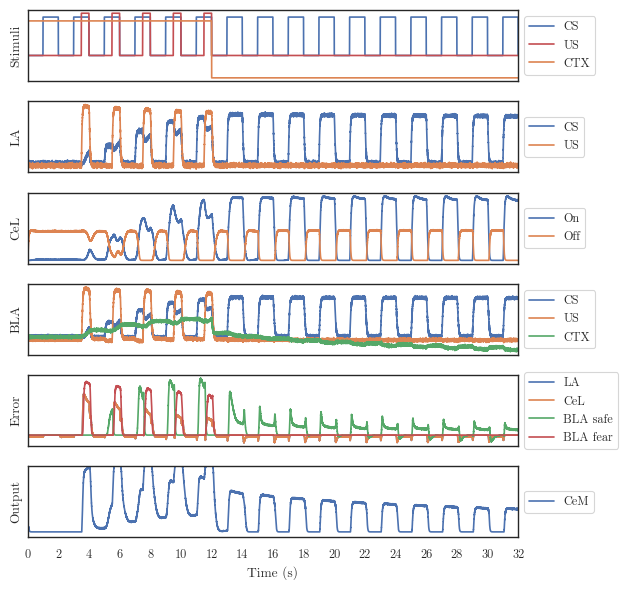

In [35]:
basic_dynamics()

## Acquisition, Extinction, and Testing

In [10]:
def aquisition_extinction_testing(
        seeds=1,
        nNeurons=100,
        dt=1e-3,
        nCond=5,
        nExt=10,
        nTest=10,
        dim_CS=3,
        dim_CTX=5,
        nCS=1,
        nCTX=3,
        load=False,
    ):

    if load:
        data_fear = pd.read_pickle(f"data/dynamics_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")
    else:
        columns = ["seed", "Context", "Phase", "cue", "Defensive Response"]
        rng = np.random.RandomState(seeds)
        dfs = []
        for s in range(seeds):
            print(f"seed={s}")
            seed = s
            lr1 = rng.uniform(2e-5, 4e-5)
            lr2 = rng.uniform(2e-4, 6e-4)
            lr3 = rng.uniform(8e-6, 2e-5)
            T_BLA_CS = rng.uniform(0.2, 0.4)
            T_BLA_CTX = rng.uniform(0.5, 1.0)
            net = build_network(seed=s, lr1=lr1, lr2=lr2, lr3=lr3, T_BLA_CS=T_BLA_CS, T_BLA_CTX=T_BLA_CTX,
                dt=dt, nNeurons=nNeurons, nCond=nCond, nExt=nExt, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, nCS=nCS)
            for c, ctx in enumerate(net.inputs.CTXs[:2]):
                ctx_label = ["CTX+", "CTX-"][c]
                # print(ctx_label)
                sim = nengo.Simulator(net, dt=dt, progress_bar=False)
                cue = 0
                with sim:
                    net.inputs.stop_learning = 0
                    # print("control")
                    net.inputs.CS = net.inputs.CSs[0]
                    net.inputs.CTX = net.inputs.CTXs[0]
                    sim.run(2)
                    Tstart = int(1/dt)
                    Tend = int(2/dt)
                    fear = np.mean(sim.data[net.pCeM][Tstart: Tend])
                    dfs.append(pd.DataFrame([[seed, ctx_label, 'Baseline', cue, fear]], columns=columns))
                    cue += 1
                    # print("acquisition")
                    net.inputs.CTX = net.inputs.CTXs[0]
                    net.inputs.US = 1
                    for p in range(nCond):
                        sim.run(2)
                        Tstart = int((2+2*cue-1)/dt)
                        Tend = int((2+2*cue-0.5)/dt)
                        fear = np.mean(sim.data[net.pCeM][Tstart: Tend])
                        dfs.append(pd.DataFrame([[seed, ctx_label, 'Acquisition', cue, fear]], columns=columns))
                        cue += 1
                    # print("extinction")
                    net.inputs.CTX = ctx
                    net.inputs.US = 0
                    for p in range(nExt):
                        sim.run(2)
                        Tstart = int((2+2*cue-1)/dt)
                        Tend = int((2+2*cue-0.5)/dt)
                        fear = np.mean(sim.data[net.pCeM][Tstart: Tend])
                        dfs.append(pd.DataFrame([[seed, ctx_label, 'Extinction', cue, fear]], columns=columns))
                        cue += 1
                    # for this experiment, keep learning ON for testing
                    # net.inputs.stop_learning = 1
                    # print("testing")
                    net.inputs.CTX = ctx
                    net.inputs.US = 0
                    for p in range(nTest):
                        sim.run(2)
                        Tstart = int((2+2*cue-1)/dt)
                        Tend = int((2+2*cue-0.5)/dt)
                        fear = np.mean(sim.data[net.pCeM][Tstart: Tend])
                        dfs.append(pd.DataFrame([[seed, ctx_label, 'Testing', cue, fear]], columns=columns))
                        cue += 1
        data_fear = pd.concat(dfs, ignore_index=True)
        data_fear.to_pickle(f"data/dynamics_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((6.38, 2)))
    sns.lineplot(data=data_fear, x='cue', y='Defensive Response', hue='Context', palette=palette[:2], marker="o", ax=ax)
    ax.axvline(1)
    ax.axvline(nCond)
    ax.axvline(nCond+nExt)
    # ax.set(xlabel=None, xticks=range(1+nCond+nExt+nTest), yticks=((0, 0.25, 0.5, 0.75, 1.0)))
    ax.set(xlabel=None, xticks=[0,nCond,nCond+nExt,nCond+nExt+nTest],
           xticklabels=["Control", "Acquisition", "Extinction", "Testing"], yticks=((0, 0.25, 0.5, 0.75, 1.0)))
    plt.tight_layout()
    fig.savefig(f"plots/dynamics_dimCS={dim_CS}_dimCTX={dim_CTX}.svg")
    fig.savefig(f"plots/dynamics_dimCS={dim_CS}_dimCTX={dim_CTX}.png", dpi=600)
    

seed=0
seed=1
seed=2
seed=3
seed=4
seed=5
seed=6
seed=7
seed=8
seed=9


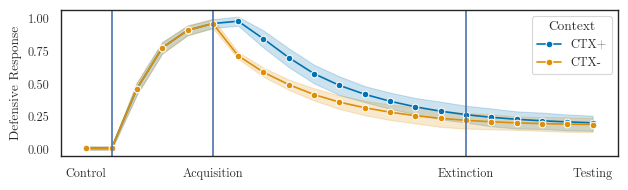

In [11]:
aquisition_extinction_testing(seeds=10, nCond=5, nExt=10, nTest=5, load=False)

## Transformation of CS Representations During Acquisition

In [38]:
def changing_CS_representation(
        seeds=1,
        nNeurons=100,
        dt=1e-3,
        nCond=5,
        nExt=10,
        nTest=10,
        dim_CS=3,
        dim_CTX=5,
        nCS=1,
        nCTX=3,
        load=False,
    ):

    if load:
        data_activity = pd.read_pickle(f"data/CSrepresentation_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")
    else:
        rng = np.random.RandomState(seeds)
        filter = nengo.Lowpass(0.1)
        dfs = []
        for s in range(seeds):
            print(f"seed={s}")
            seed = s
            lr1 = rng.uniform(2e-5, 4e-5)
            lr2 = rng.uniform(2e-4, 6e-4)
            lr3 = rng.uniform(8e-6, 2e-5)
            T_BLA_CS = rng.uniform(0.2, 0.4)
            T_BLA_CTX = rng.uniform(0.5, 1.0)
            net = build_network(seed=s, lr1=lr1, lr2=lr2, lr3=lr3, T_BLA_CS=T_BLA_CS, T_BLA_CTX=T_BLA_CTX,
                dt=dt, nNeurons=nNeurons, nCond=nCond, nExt=nExt, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, nCS=nCS)
            sim = nengo.Simulator(net, dt=dt, progress_bar=False)
            with sim:
                net.inputs.stop_learning = 0
                net.inputs.CS = net.inputs.CSs[0]
                net.inputs.CTX = net.inputs.CTXs[0]
                net.inputs.US = 1
                for p in range(nCond):
                    sim.run(2)
            for neuron in range(2*nNeurons):
                US_encoder = sim.data[net.LA_pyr].encoders[neuron,1]
                if US_encoder > 0.9: alignment = 'aligned'
                elif US_encoder < -0.9: alignment = 'antialigned'
                elif -0.2 < US_encoder < 0.2: alignment = 'nonaligned'
                else: aligment = "meh"
                df = pd.DataFrame()
                df['time'] = sim.trange()
                df['alignment'] = [alignment for _ in range(len(sim.trange()))]
                df['neuron'] = neuron*np.ones_like(sim.trange())
                # df['firing rate'] = sim.data[net.pLA_pyr_spikes][:,neuron].ravel()
                df['firing rate'] = filter.filt(sim.data[net.pLA_pyr_spikes][:,neuron].ravel())
                dfs.append(df)
        data_activity = pd.concat(dfs, ignore_index=True)
        data_activity.to_pickle(f"data/CSrepresentation_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")

    aligned_neuron_idx = data_activity.query("alignment=='aligned'")['neuron'].unique()
    nonaligned_neuron_idx = data_activity.query("alignment=='nonaligned'")['neuron'].unique()
    antialigned_neuron_idx = data_activity.query("alignment=='antialigned'")['neuron'].unique()


    Tus1 = 1.5
    Tus2 = 2
    Tearly1 = 1
    Tearly2 = 1.5
    Tmiddle1 = 2*int(nCond/2)+1
    Tmiddle2 = 2*int(nCond/2)+1.5
    Tlate1 = 2*(nCond-1)+1
    Tlate2 = 2*(nCond-1)+1.5
    us = data_activity.query("time>@Tus1 and time<@Tus2")
    early = data_activity.query("time>@Tearly1 and time<@Tearly2")
    middle = data_activity.query("time>@Tmiddle1 and time<@Tmiddle2")
    late = data_activity.query("time>@Tlate1 and time<@Tlate2")
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=((6.38, 2)))
    sns.barplot(data=early, x='neuron', y='firing rate', ax=axes[0], color=palette[0], label='CS Response', errorbar=None, alpha=0.5)
    # sns.barplot(data=middle, x='neuron', y='firing rate', ax=axes[1], color=palette[0], label='CS Response', errorbar=None, alpha=0.5)
    sns.barplot(data=late, x='neuron', y='firing rate', ax=axes[1], color=palette[0], label='CS Response', errorbar=None, alpha=0.5)
    sns.barplot(data=us, x='neuron', y='firing rate', ax=axes[0], color=palette[1], label='US Response', errorbar=None, alpha=0.5)
    # sns.barplot(data=us, x='neuron', y='firing rate', ax=axes[1], color=palette[1], label='US Response', errorbar=None, alpha=0.5)
    sns.barplot(data=us, x='neuron', y='firing rate', ax=axes[1], color=palette[1], label='US Response', errorbar=None, alpha=0.5)
    axes[0].legend()
    axes[1].get_legend().remove()
    # axes[2].get_legend().remove()
    axes[0].set(xlabel="Neuron", ylabel="Firing Rate (Hz)", title="Before Acquisition")
    # axes[1].set(ylabel="Firing Rate (Hz)", title="During Acquisition")
    axes[1].set(xlabel="Neuron", ylabel="Firing Rate (Hz)", title="After Acquisition", xticks=[])
    plt.tight_layout()
    fig.savefig(f"plots/CSrepresentation_dimCS={dim_CS}_dimCTX={dim_CTX}.svg")
    fig.savefig(f"plots/CSrepresentation_dimCS={dim_CS}_dimCTX={dim_CTX}.png", dpi=600)

    # print(data_activity)
    N1 = aligned_neuron_idx[0]
    N2 = nonaligned_neuron_idx[0]
    N3 = antialigned_neuron_idx[0]
    aligned = data_activity.query("neuron==@N1")  # in @aligned_neuron_idx")
    nonaligned = data_activity.query("neuron==@N2")  # in @nonaligned_neuron_idx")
    antialigned = data_activity.query("neuron==@N3")  # in @antialigned_neuron_idx")
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=((6.38, 2)))
    sns.lineplot(data=aligned, x='time', y='firing rate', ax=axes[0], color=palette[0])
    sns.lineplot(data=antialigned, x='time', y='firing rate', ax=axes[1], color=palette[0])
    sns.lineplot(data=nonaligned, x='time', y='firing rate', ax=axes[2], color=palette[0])
    for p in range(nCond):
        axes[0].axvspan(2*p+1, 2*p+1.5, alpha=0.5, color=palette[2])
        axes[0].axvspan(2*p+1.5, 2*p+2, alpha=0.5, color=palette[3])
        axes[1].axvspan(2*p+1, 2*p+1.5, alpha=0.5, color=palette[2])
        axes[1].axvspan(2*p+1.5, 2*p+2, alpha=0.5, color=palette[3])
        axes[2].axvspan(2*p+1, 2*p+1.5, alpha=0.5, color=palette[2])
        axes[2].axvspan(2*p+1.5, 2*p+2, alpha=0.5, color=palette[3])
    axes[0].set(xlabel="Time (s)", ylabel="Firing Rate (Hz)", title="Potentiating", yticks=[0, 100, 200], xticks=np.arange(0, 1+nCond*2, 1))
    axes[1].set(xlabel="Time (s)", ylabel="Firing Rate (Hz)", title="Depressing", xticks=np.arange(0, 1+nCond*2, 1))
    axes[2].set(xlabel="Time (s)", ylabel="Firing Rate (Hz)", title="Other", xticks=np.arange(0, 1+nCond*2, 1))
    plt.tight_layout()
    fig.savefig(f"plots/aligned_dimCS={dim_CS}_dimCTX={dim_CTX}.svg")
    fig.savefig(f"plots/aligned_dimCS={dim_CS}_dimCTX={dim_CTX}.png", dpi=600)

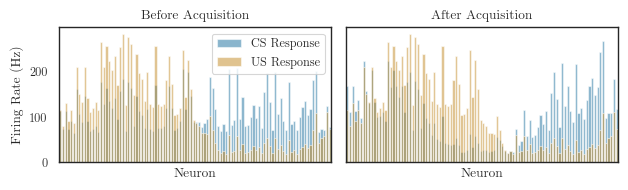

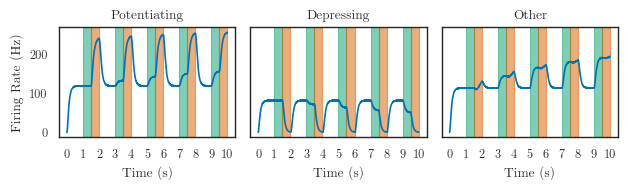

In [39]:
changing_CS_representation(seeds=1, nCond=5, nNeurons=50, load=True)

## Fear Expression and Neural Responses

In [10]:
def fear_expression_neural_responses(
        seeds=1,
        nNeurons=100,
        dt=1e-3,
        nCond=5,
        nExt=10,
        dim_CS=3,
        dim_CTX=5,
        nCS=1,
        nCTX=3,
        load=False,
        plot=False,
    ):

    if load:
        data_fear = pd.read_pickle(f"data/expression_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")
        data_activity = pd.read_pickle(f"data/activity_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")
        data_types = pd.read_pickle(f"data/types_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")
    else:
        dfs_fear = []
        dfs_activity = []
        dfs_types = []
        columns_fear = ["seed", "Fear Response", "Experiment"]
        columns_activity = ["seed", "Type", "Activity", "Experiment"]
        columns_types = ["seed", "Type", "Percent"]
        rng = np.random.RandomState(seeds)

        for s in range(seeds):
            print(f"seed={s}")
            seed = s
            lr1 = rng.uniform(2e-5, 4e-5)
            lr2 = rng.uniform(2e-4, 6e-4)
            lr3 = rng.uniform(8e-6, 2e-5)
            T_BLA_CS = rng.uniform(0.2, 0.4)
            T_BLA_CTX = rng.uniform(0.5, 1.0)
            net = build_network(seed=s, lr1=lr1, lr2=lr2, lr3=lr3, T_BLA_CS=T_BLA_CS, T_BLA_CTX=T_BLA_CTX,
                dt=dt, nNeurons=nNeurons, nCond=nCond, nExt=nExt, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, nCS=nCS)
            sim = nengo.Simulator(net, dt=dt, progress_bar=False)
            with sim:
                net.inputs.stop_learning = 0
                print("control")
                net.inputs.CS = net.inputs.CSs[0]
                net.inputs.CTX = net.inputs.CTXs[0]
                sim.run(2)
                T1a = int(1/dt)
                T1b = int(2/dt)
                print("conditioning")
                net.inputs.CTX = net.inputs.CTXs[0]
                net.inputs.US = 1
                for p in range(nCond):
                    sim.run(2)
                T2a = int((2+2*nCond-1)/dt)
                T2b = int((2+2*nCond-0.5)/dt)
                print("extinction")
                net.inputs.CTX = net.inputs.CTXs[1]
                net.inputs.US = 0
                for p in range(nExt):
                    sim.run(2)
                T3a = int((2+2*nCond+2*nExt-1)/dt)
                T3b = int((2+2*nCond+2*nExt-0.5)/dt)
        #         print("turn learning off for testing")
                net.inputs.stop_learning = 1
                print("test CTX A")
                net.inputs.CTX = net.inputs.CTXs[0]
                net.inputs.US = 0
                sim.run(2)
                T4a = int((2+2*nCond+2*nExt+1)/dt)
                T4b = int((2+2*nCond+2*nExt+1.5)/dt)
                print("test CTX B")
                net.inputs.CTX = net.inputs.CTXs[1]
                net.inputs.US = 0
                sim.run(2)
                T5a = int((2+2*nCond+2*nExt+2+1)/dt)
                T5b = int((2+2*nCond+2*nExt+2+1.5)/dt)  
                print("test CTX C")
                net.inputs.CTX = net.inputs.CTXs[2]
                net.inputs.US = 0
                sim.run(2)
                T6a = int((2+2*nCond+2*nExt+2+2+1)/dt)
                T6b = int((2+2*nCond+2*nExt+2+2+1.5)/dt)  

            if plot:
                ctxA_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[0])[0]
                ctxB_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[1])[0]
                ctxC_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[2])[0]
                ctx_signal = np.zeros((sim.trange().shape[0]))
                ctx_signal2 = np.zeros((sim.trange().shape[0]))
                ctx_signal[ctxB_idx] = 1
                ctx_signal2[ctxC_idx] = 0.5
                fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [2,2,4,4]})
                axes[0].plot(sim.trange(), sim.data[net.pCeM])
                axes[0].set(ylabel=r"$\hat{x}$", title="Fear Response", yticks=((0,1)))
                axes[1].plot(sim.trange(), 1.4*np.linalg.norm(sim.data[net.pCS], ord=2, axis=1), label="CS present")
                axes[1].plot(sim.trange(), 1.8*sim.data[net.pUS], label="US", c='r')
                axes[1].plot(sim.trange(), ctx_signal)
                axes[1].plot(sim.trange(), ctx_signal2)
                axes[1].set(yticks=((0,0.5,1,1.4,1.8)), yticklabels=(("CTX+","CTXn","CTX-","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
                axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,0], label="BLA_pyr_CS")
                axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,1], label="BLA_pyr_US")
                axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,2], label="BLA_pyr_CTX")
                axes[2].legend()
                axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
                axes[3].plot(sim.trange(), sim.data[net.pError_LA], label="CS minus US")
                axes[3].plot(sim.trange(), sim.data[net.pError_BLA_safe], label="CS minus CTX")
                axes[3].plot(sim.trange(), sim.data[net.pError_BLA_fear], label="US minus CTX")
                axes[3].legend()
                axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
                plt.tight_layout()

            dfs_fear.append(pd.DataFrame([[seed, np.mean(sim.data[net.pCeM][T1a: T1b]), "Control"]], columns=columns_fear))
            dfs_fear.append(pd.DataFrame([[seed, np.mean(sim.data[net.pCeM][T4a: T4b]), "CTX+"]], columns=columns_fear))
            dfs_fear.append(pd.DataFrame([[seed, np.mean(sim.data[net.pCeM][T5a: T5b]), "CTX-"]], columns=columns_fear))
            dfs_fear.append(pd.DataFrame([[seed, np.mean(sim.data[net.pCeM][T6a: T6b]), "CTX*"]], columns=columns_fear))

            aControl_LA_pyr = sim.data[net.pLA_pyr_spikes][T1a: T1b]
            aConditioning_LA_pyr = sim.data[net.pLA_pyr_spikes][T4a: T4b]
            aExtinction_LA_pyr = sim.data[net.pLA_pyr_spikes][T5a: T5b]
            aControl_CeL_on = sim.data[net.pCeL_on_spikes][T1a: T1b]
            aConditioning_CeL_on = sim.data[net.pCeL_on_spikes][T4a: T4b]
            aExtinction_CeL_on = sim.data[net.pCeL_on_spikes][T5a: T5b]
            aControl_CeL_off = sim.data[net.pCeL_off_spikes][T1a: T1b]
            aConditioning_CeL_off = sim.data[net.pCeL_off_spikes][T4a: T4b]
            aExtinction_CeL_off = sim.data[net.pCeL_off_spikes][T5a: T5b]
            aControl_BLA = sim.data[net.pBLA_pyr_spikes][T1a: T1b]
            aConditioning_BLA = sim.data[net.pBLA_pyr_spikes][T4a: T4b]
            aExtinction_BLA = sim.data[net.pBLA_pyr_spikes][T5a: T5b]

            LA_pyr_up = np.where(np.mean(aConditioning_LA_pyr, axis=0) > 1.5*np.mean(aControl_LA_pyr, axis=0))[0]
            LA_pyr_down = np.where(np.mean(aConditioning_LA_pyr, axis=0) < 0.5*np.mean(aControl_LA_pyr, axis=0))[0]
            fear_neurons_p1 = np.where(np.mean(aConditioning_BLA, axis=0) > 1.5*np.mean(aControl_BLA, axis=0))[0]
            fear_neurons_p2 = np.where(np.mean(aExtinction_BLA, axis=0) < 0.5*np.mean(aConditioning_BLA, axis=0))[0]
            fear_neurons = np.intersect1d(fear_neurons_p1, fear_neurons_p2)
            extinction_neurons = np.where(np.mean(aExtinction_BLA, axis=0) > 1.5*np.mean(aConditioning_BLA, axis=0))[0]
            persistent_neurons = np.where(np.abs(np.mean(aConditioning_BLA-aExtinction_BLA,axis=0))<0.5*np.mean(aConditioning_BLA, axis=0))[0]
            
            dfs_activity.append(pd.DataFrame([[seed, "LA Up", np.mean(aControl_LA_pyr[:,LA_pyr_up]), "Control"]], columns=columns_activity))
            dfs_activity.append(pd.DataFrame([[seed, "LA Up", np.mean(aConditioning_LA_pyr[:,LA_pyr_up]), "CTX+"]], columns=columns_activity))
            dfs_activity.append(pd.DataFrame([[seed, "LA Up", np.mean(aExtinction_LA_pyr[:,LA_pyr_up]), "CTX-"]], columns=columns_activity))
            dfs_activity.append(pd.DataFrame([[seed, "LA Down", np.mean(aControl_LA_pyr[:,LA_pyr_down]), "Control"]], columns=columns_activity))
            dfs_activity.append(pd.DataFrame([[seed, "LA Down", np.mean(aConditioning_LA_pyr[:,LA_pyr_down]), "CTX+"]], columns=columns_activity))
            dfs_activity.append(pd.DataFrame([[seed, "LA Down", np.mean(aExtinction_LA_pyr[:,LA_pyr_down]), "CTX-"]], columns=columns_activity))
            dfs_activity.append(pd.DataFrame([[seed, "BLA Fear", np.mean(aControl_BLA[:,fear_neurons]), "Control"]], columns=columns_activity))
            dfs_activity.append(pd.DataFrame([[seed, "BLA Fear", np.mean(aConditioning_BLA[:,fear_neurons]), "CTX+"]], columns=columns_activity))
            dfs_activity.append(pd.DataFrame([[seed, "BLA Fear", np.mean(aExtinction_BLA[:,fear_neurons]), "CTX-"]], columns=columns_activity))
            dfs_activity.append(pd.DataFrame([[seed, "BLA Persist", np.mean(aControl_BLA[:,persistent_neurons]), "Control"]], columns=columns_activity))
            dfs_activity.append(pd.DataFrame([[seed, "BLA Persist", np.mean(aConditioning_BLA[:,persistent_neurons]), "CTX+"]], columns=columns_activity))
            dfs_activity.append(pd.DataFrame([[seed, "BLA Persist", np.mean(aExtinction_BLA[:,persistent_neurons]), "CTX-"]], columns=columns_activity))
            dfs_activity.append(pd.DataFrame([[seed, "BLA Extinct", np.mean(aControl_BLA[:,extinction_neurons]), "Control"]], columns=columns_activity))
            dfs_activity.append(pd.DataFrame([[seed, "BLA Extinct", np.mean(aConditioning_BLA[:,extinction_neurons]), "CTX+"]], columns=columns_activity))
            dfs_activity.append(pd.DataFrame([[seed, "BLA Extinct", np.mean(aExtinction_BLA[:,extinction_neurons]), "CTX-"]], columns=columns_activity))
            dfs_activity.append(pd.DataFrame([[seed, "CeL On", np.mean(aControl_CeL_on), "Control"]], columns=columns_activity))
            dfs_activity.append(pd.DataFrame([[seed, "CeL On", np.mean(aConditioning_CeL_on), "CTX+"]], columns=columns_activity))
            dfs_activity.append(pd.DataFrame([[seed, "CeL On", np.mean(aExtinction_CeL_on), "CTX-"]], columns=columns_activity))
            dfs_activity.append(pd.DataFrame([[seed, "CeL Off", np.mean(aControl_CeL_off), "Control"]], columns=columns_activity))
            dfs_activity.append(pd.DataFrame([[seed, "CeL Off", np.mean(aConditioning_CeL_off), "CTX+"]], columns=columns_activity))
            dfs_activity.append(pd.DataFrame([[seed, "CeL Off", np.mean(aExtinction_CeL_off), "CTX-"]], columns=columns_activity))

            percent_up = len(LA_pyr_up)/(2*nNeurons)*100
            percent_down = len(LA_pyr_down)/(2*nNeurons)*100
            percent_fear = len(fear_neurons)/(4*nNeurons)*100
            percent_extinction = len(extinction_neurons)/(4*nNeurons)*100
            percent_persistent = len(persistent_neurons)/(4*nNeurons)*100

            dfs_types.append(pd.DataFrame([[seed, "LA Up", percent_up]], columns=columns_types))
            dfs_types.append(pd.DataFrame([[seed, "LA Down", percent_down]], columns=columns_types))
            dfs_types.append(pd.DataFrame([[seed, "BLA Fear", percent_fear]], columns=columns_types))
            dfs_types.append(pd.DataFrame([[seed, "BLA Extinct", percent_extinction]], columns=columns_types))
            dfs_types.append(pd.DataFrame([[seed, "BLA Persist", percent_persistent]], columns=columns_types))

        data_fear = pd.concat(dfs_fear, ignore_index=True)
        data_activity = pd.concat(dfs_activity, ignore_index=True)
        data_types = pd.concat(dfs_types, ignore_index=True)
        data_fear.to_pickle(f"data/expression_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")
        data_activity.to_pickle(f"data/activity_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")
        data_types.to_pickle(f"data/types_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")

    emps = []
    emps.append(pd.DataFrame([[(0.5-0.4)/6, "Control"]], columns=["Fear Response", "Experiment"]))
    emps.append(pd.DataFrame([[(5.6-0.5)/6, "Acquisition"]], columns=["Fear Response", "Experiment"]))
    emps.append(pd.DataFrame([[(1.5-0.2)/6, "Extinction"]], columns=["Fear Response", "Experiment"]))
    emps.append(pd.DataFrame([[(5.6-3.2)/6, "Reinstatement"]], columns=["Fear Response", "Experiment"]))
    emp_fear = pd.concat(emps, ignore_index=True) 

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((6.38, 2)), sharey=True)   
    sns.barplot(data=emp_fear, x='Experiment', y="Fear Response", palette=palette[:4], hue='Experiment', ax=axes[0])
    sns.barplot(data=data_fear, x='Experiment', y="Fear Response", palette=palette[:4], hue='Experiment', ax=axes[1])
    axes[0].set(ylabel="Fear Response", xlabel=None, xticks=[0,1,2,3], xticklabels=["Control", "Acquisition", "Extinction", "Reinstate"], yticks=((0, 0.25, 0.5, 0.75, 1.0)), title="Empirical Data")
    axes[1].set(ylabel="Defensive Response", xlabel=None, xticks=[0,1,2,3], xticklabels=["Control", r"CTX$^+$", r"CTX$^-$", r"CTX$^*$"], yticks=((0, 0.25, 0.5, 0.75, 1.0)), title="Model Data")
    # axes[0].set(ylabel="Fear Response", xlabel=None, xticks=[0,1,2,3], xticklabels=["Control", "Acquisition", "Extinction", "Renewal"], yticks=[], title="Empirical Data")
    # axes[1].set(ylabel="Defensive Response", xlabel=None, xticks=[0,1,2,3], xticklabels=["Control", "Acquisition", "Extinction", "Renewal"], yticks=[], title="Model Data")
    plt.tight_layout()
    fig.savefig(f"plots/Figure3.svg")
    fig.savefig(f"plots/Figure3.png", dpi=600)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((6.38, 2)))
    sns.barplot(data=data_activity, x='Type', y="Activity", hue="Experiment", palette=palette[:3], ax=ax)
    ax.set(xlabel=None, ylabel="Mean Firing Rate (Hz)", yticks=((0,100,200,300)))
    plt.legend(loc='upper right')
    plt.tight_layout()
    fig.savefig(f"plots/Figure6.svg")
    fig.savefig(f"plots/Figure6.png", dpi=600)
    
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=((6.38,2)), sharey=True)
    sns.histplot(data=data_types.query("Type=='LA up'")['Percent'], stat="percent", bins=10, ax=axes[0])
    sns.histplot(data=data_types.query("Type=='LA down'")['Percent'], stat="percent", bins=10, ax=axes[1])
    sns.histplot(data=data_types.query("Type=='BLA Fear'")['Percent'], stat="percent", bins=10, ax=axes[2])
    sns.histplot(data=data_types.query("Type=='BLA Persist'")['Percent'], stat="percent", bins=10, ax=axes[3])
    sns.histplot(data=data_types.query("Type=='BLA Extinct'")['Percent'], stat="percent", bins=10, ax=axes[4])
    axes[0].set(title="LA Up", ylabel="Frequency\nacross networks", xticks=((20,27,34)))
    axes[1].set(title="LA Down", xticks=((33,36,39)))
    axes[2].set(title="BLA Fear", xticks=((4,6,8)))
    axes[3].set(title="BLA Persist", xticks=((25,30,35)))
    axes[4].set(title="BLA Extinct", xticks=((5,10,15)))
    plt.tight_layout()
    fig.savefig(f"plots/ResponseTypes.svg")
    fig.savefig(f"plots/ResponseTypes.png", dpi=600)


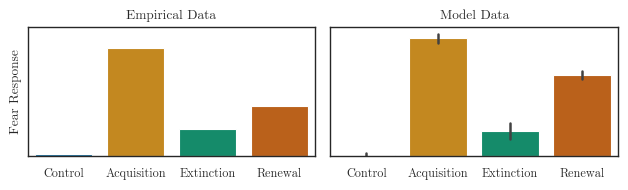

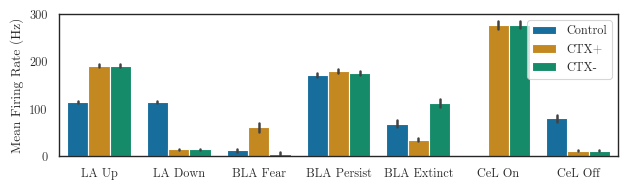

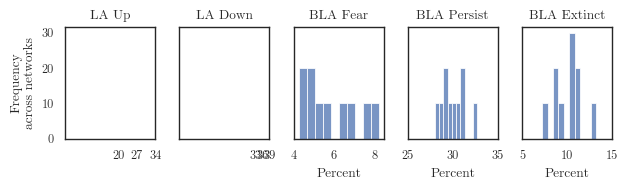

In [11]:
fear_expression_neural_responses(seeds=10, plot=False, load=True)

## Perturbation Experiments (external activation or inactivation)

In [28]:
def perturbation_experiment(
        seeds=1,
        nNeurons=100,
        dt=1e-3,
        nCond=5,
        nExt=10,
        dim_CS=3,
        dim_CTX=5,
        nCS=1,
        nCTX=3,
        T_current=2,
        perturbation="None",  # inject positive or negative current
        perturb_where="LApyr",  # which population to inject the current into
        perturb_during=["Acquisition", "Extinction", "Test in CTX+", "Test in CTX-"]):  # during which phase of the protocol will the injection happen
 
    dfs = []
    rng = np.random.RandomState(seeds)

    for seed in range(seeds):
        lr1 = rng.uniform(2e-5, 4e-5)
        lr2 = rng.uniform(2e-4, 6e-4)
        lr3 = rng.uniform(8e-6, 2e-5)
        T_BLA_CS = rng.uniform(0.2, 0.4)
        T_BLA_CTX = rng.uniform(0.5, 1.0)
        for when in perturb_during:
            net = build_network(seed=seed, lr1=lr1, lr2=lr2, lr3=lr3, T_BLA_CS=T_BLA_CS, T_BLA_CTX=T_BLA_CTX,
                dt=dt, nNeurons=nNeurons, nCond=nCond, nExt=nExt, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, nCS=nCS)
            with net:
                if perturb_where=="LApyr":
                    nengo.Connection(net.applied_current, net.LA_pyr.neurons, transform=np.ones((2*nNeurons, 1)))
                if perturb_where=="LAinh":
                    nengo.Connection(net.applied_current, net.LA_inh.neurons, transform=np.ones((2*nNeurons, 1)))
                if perturb_where=="BLApyr":
                    nengo.Connection(net.applied_current, net.BLA_pyr.neurons, transform=np.ones((3*nNeurons, 1)))
                if perturb_where=="BLAinh":
                    nengo.Connection(net.applied_current, net.BLA_inh.neurons, transform=np.ones((2*nNeurons, 1)))
                if perturb_where=="CeL":
                    nengo.Connection(net.applied_current, net.CeL_on.neurons, transform=np.ones((nNeurons, 1)))
                    nengo.Connection(net.applied_current, net.CeL_off.neurons, transform=np.ones((nNeurons, 1)))
                if perturb_where=="CeM":
                    nengo.Connection(net.applied_current, net.CeM.neurons, transform=np.ones((nNeurons, 1)))
                net.pApplied = nengo.Probe(net.applied_current)
            sim = nengo.Simulator(net, dt=dt, progress_bar=False)
            with sim:
                net.inputs.applied_current = 0
                net.inputs.stop_learning = 0
                net.inputs.CS = net.inputs.CSs[0]
                net.inputs.CTX = net.inputs.CTXs[0]
                # if when=="Control" and perturbation=="Positive":
                #     net.inputs.applied_current = T_current
                # elif when=="Control" and perturbation=="Negative":
                #     net.inputs.applied_current = -T_current
                # else:
                #     net.inputs.applied_current = 0
                sim.run(2)
                T1a = int(1/dt)
                T1b = int(2/dt)
                net.inputs.CTX = net.inputs.CTXs[0]
                net.inputs.US = 1
                if when=="Acquisition" and perturbation=="Positive":
                    net.inputs.applied_current = T_current
                elif when=="Acquisition" and perturbation=="Negative":
                    net.inputs.applied_current = -T_current
                else:
                    net.inputs.applied_current = 0
                for p in range(nCond):
                    sim.run(2)
                T2a = int((2+2*nCond-1)/dt)
                T2b = int((2+2*nCond-0.5)/dt)
                net.inputs.CTX = net.inputs.CTXs[1]
                net.inputs.US = 0
                if when=="Extinction" and perturbation=="Positive":
                    net.inputs.applied_current = T_current
                elif when=="Extinction" and perturbation=="Negative":
                    net.inputs.applied_current = -T_current
                else:
                    net.inputs.applied_current = 0
                for p in range(nExt):
                    sim.run(2)
                T3a = int((2+2*nCond+2*nExt-1)/dt)
                T3b = int((2+2*nCond+2*nExt-0.5)/dt)
                net.inputs.stop_learning = 1
                if when=="Test in CTX+" and perturbation=="Positive":
                    net.inputs.applied_current = T_current
                elif when=="Test in CTX+" and perturbation=="Negative":
                    net.inputs.applied_current = -T_current
                else:
                    net.inputs.applied_current = 0
                net.inputs.CTX = net.inputs.CTXs[0]
                net.inputs.US = 0
                sim.run(2)
                T4a = int((2+2*nCond+2*nExt+1)/dt)
                T4b = int((2+2*nCond+2*nExt+1.5)/dt)
                if when=="Test in CTX-" and perturbation=="Positive":
                    net.inputs.applied_current = T_current
                elif when=="Test in CTX-" and perturbation=="Negative":
                    net.inputs.applied_current = -T_current
                else:
                    net.inputs.applied_current = 0
                net.inputs.CTX = net.inputs.CTXs[1]
                net.inputs.US = 0
                sim.run(2)
                T5a = int((2+2*nCond+2*nExt+2+1)/dt)
                T5b = int((2+2*nCond+2*nExt+2+1.5)/dt)

            columns = ["seed", "Perturb Where", "Perturb During", "Test Context", "Perturbation", "Fear Response"]
            # dfs.append(pd.DataFrame([[seed, where, when, "Control", np.mean(sim.data[net.pCeM][T1a: T1b]), stim, block]], columns=columns))
            if when!="Test in CTX-": dfs.append(pd.DataFrame([[seed, perturb_where, when, "CTX+", perturbation, np.mean(sim.data[net.pCeM][T4a: T4b])]], columns=columns))
            if when!="Test in CTX+": dfs.append(pd.DataFrame([[seed, perturb_where, when, "CTX-", perturbation, np.mean(sim.data[net.pCeM][T5a: T5b])]], columns=columns))

    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/perturbation_{perturbation}_{perturb_where}.pkl")

In [29]:
perturbation_experiment(seeds=10, perturb_where="None", perturbation="None")

C:\Users\Peter Duggins\amygdala\.venv\Lib\site-packages\nengo\cache.py:624: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


In [30]:
perturbation_experiment(seeds=10, perturb_where="LApyr", perturbation="Negative")

In [31]:
perturbation_experiment(seeds=10, perturb_where="LAinh", perturbation="Negative")

In [32]:
perturbation_experiment(seeds=10, perturb_where="BLApyr", perturbation="Negative")

In [33]:
perturbation_experiment(seeds=10, perturb_where="BLAinh", perturbation="Negative")

In [34]:
perturbation_experiment(seeds=10, perturb_where="CeL", perturbation="Negative")

In [35]:
perturbation_experiment(seeds=10, perturb_where="CeM", perturbation="Negative")

In [37]:
perturbation_experiment(seeds=10, perturb_where="CeL", perturbation="Positive")

C:\Users\Peter Duggins\amygdala\.venv\Lib\site-packages\nengo\cache.py:624: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


In [38]:
perturbation_experiment(seeds=10, perturb_where="CeM", perturbation="Positive")

### Inactivation experiment

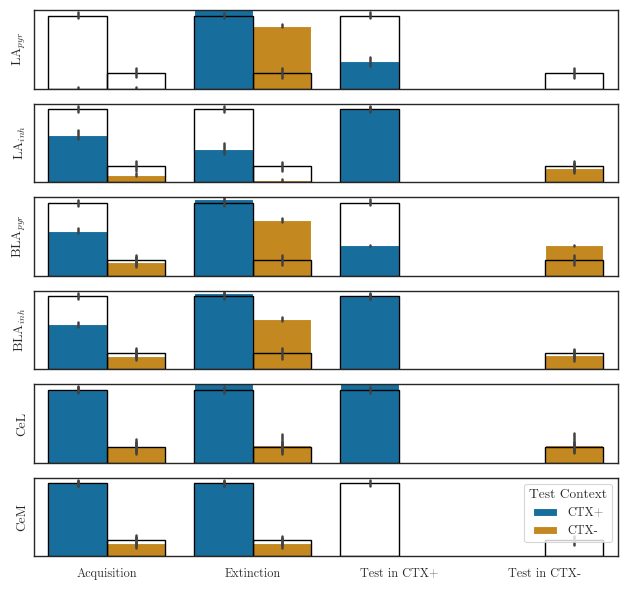

In [36]:
perturbation = "Negative"
perturb_wheres = ["LApyr", "LAinh", "BLApyr", "BLAinh", "CeL", "CeM"]
labels = [r"LA$_{pyr}$", r"LA$_{inh}$", r"BLA$_{pyr}$", r"BLA$_{inh}$", "CeL", "CeM"]
fig, axes = plt.subplots(nrows=len(perturb_wheres), ncols=1, sharex=True, figsize=((6.38, 6)))

control = pd.read_pickle(f"data/perturbation_None_None.pkl")
for i, where in enumerate(perturb_wheres):
    data = pd.read_pickle(f"data/perturbation_{perturbation}_{where}.pkl")
    sns.barplot(data=data, x='Perturb During', y='Fear Response', hue="Test Context", ax=axes[i], palette=palette[:2])
    sns.barplot(data=control, x='Perturb During', y='Fear Response', hue="Test Context", ax=axes[i], linewidth=1, facecolor=(0,0,0,0), edgecolor=(0,0,0,1), legend=False)
    axes[i].set(ylabel=labels[i], yticks=(()), ylim=((0, 1.0)), xlabel=None)

for i in range(len(perturb_wheres)-1):
    axes[i].get_legend().remove()
plt.tight_layout()
fig.savefig(f"plots/inactivation.png", dpi=600)
fig.savefig(f"plots/inactivation.svg")

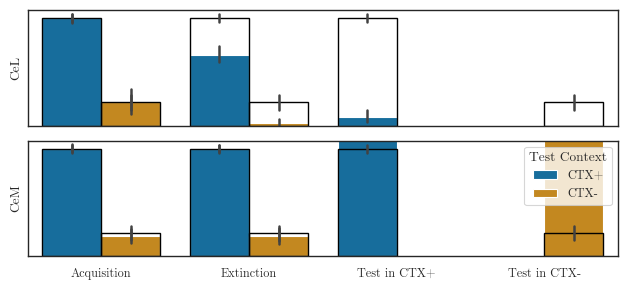

In [39]:
perturbation = "Positive"
perturb_wheres = ["CeL", "CeM"]
labels = ["CeL", "CeM"]
fig, axes = plt.subplots(nrows=len(perturb_wheres), ncols=1, sharex=True, figsize=((6.38, 3)))

control = pd.read_pickle(f"data/perturbation_None_None.pkl")
for i, where in enumerate(perturb_wheres):
    data = pd.read_pickle(f"data/perturbation_{perturbation}_{where}.pkl")
    sns.barplot(data=data, x='Perturb During', y='Fear Response', hue="Test Context", ax=axes[i], palette=palette[:2])
    sns.barplot(data=control, x='Perturb During', y='Fear Response', hue="Test Context", ax=axes[i], linewidth=1, facecolor=(0,0,0,0), edgecolor=(0,0,0,1), legend=False)
    axes[i].set(ylabel=labels[i], yticks=(()), ylim=((0, 1.0)), xlabel=None)
for i in range(len(perturb_wheres)-1):
    axes[i].get_legend().remove()
plt.tight_layout()
fig.savefig(f"plots/activation.png", dpi=600)
fig.savefig(f"plots/activation.svg")

## Fear Generalization

In [16]:
def genCS(
        seeds=1,
        nNeurons=100,
        nNeuronsExtCS=300,
        nNeuronsExtCTX=500,
        dt=1e-3,
        nCond=10,
        nCS=2,
        nCTX=1,
        dim_CS=3,
        dim_CTX=5,
        intercept_CS=0,
        intercept_CTX=0,
        load=False,
        choose_intercepts_method='fixed',
        sparsity=0.5,
        CSminusSim=0.0,
        minSim=-1.0,
        compare_empirical=False,
    ):

    if load:
        data = pd.read_pickle(f"data/genCS_intercept{intercept_CS}_dimCS={dim_CS}_dimCTX={dim_CTX}.pkl")
    else:
        rng = np.random.RandomState(seeds)
        dfs1 = []
        dfs2 = []
        columns = ["seed", "Fear Response", "Similarity to CS+"]
        for seed in range(seeds):
            print(f"seed={seed}")
            lr1 = rng.uniform(1e-4, 3e-4)
            lr2 = rng.uniform(2e-4, 6e-4)
            lr3 = rng.uniform(2e-5, 5e-5)
#             lr1 = rng.uniform(2e-5, 4e-5)
#             lr2 = rng.uniform(2e-4, 6e-4)
#             lr3 = rng.uniform(8e-6, 2e-5)
            T_BLA_CS = rng.uniform(0.2, 0.4)
            T_BLA_CTX = rng.uniform(0.5, 1.0)
            if choose_intercepts_method=='fixed':
                intCS = intercept_CS
                intCTX = intercept_CTX
            elif choose_intercepts_method=='sparsity':
                intCS = sparsity_to_x_intercept(dim_CS, sparsity)
#                 print(f"sparsity {sparsity}, dimension {dim_CS} => intercept {intCS}")
                intCTX = intercept_CTX
#                 intCTX = sparsity_to_x_intercept(dim_CTX, sparsity)                
            net = build_network(
                seed=seed, lr1=lr1, lr2=lr2, lr3=lr3, T_BLA_CS=T_BLA_CS, T_BLA_CTX=T_BLA_CTX,
                intercept_CS=intCS, intercept_CTX=intCTX,
                dt=dt, nNeurons=nNeurons, nNeuronsExtCS=nNeuronsExtCS, nNeuronsExtCTX=nNeuronsExtCTX,
                nCond=nCond, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, nCS=10000)
            sim = nengo.Simulator(net, dt=dt, progress_bar=False)
            CTX = net.inputs.CTXs[0]
            CSplus = net.inputs.CSs[0]
            similarities = np.dot(CSplus, net.inputs.CSs.T)
            CSminus = net.inputs.CSs[np.argmin(np.abs(similarities-CSminusSim))]   
#             CSminus = net.inputs.CSs[np.argmin(similarities)]
            target_similarities = np.linspace(minSim, 1, nCS)
            stims = np.array([CSplus for n in range(nCond)] + [CSminus for n in range(nCond)])
            rng.shuffle(stims)
            target_similarities2 = np.linspace(CSminusSim, 1, 6)
            with sim:
                print("acquisition")
                net.inputs.stop_learning = 0
                net.inputs.CTX = CTX
                for p in range(len(stims)):
#                     print(f"pair {p}")
                    net.inputs.CS = stims[p]
                    net.inputs.US = 1 if np.all(stims[p]==CSplus) else 0
                    sim.run(2)
                print("testing full range")
                net.inputs.stop_learning = 1
                net.inputs.US = 0
                for cs in range(nCS):
                    target_sim = target_similarities[cs]
                    CS = net.inputs.CSs[np.argmin(np.abs(similarities-target_sim))]
                    net.inputs.CS = CS
                    print(f"CS* #{cs}, similarity={np.dot(CSplus, CS):.2}")
                    sim.run(2)
                    freezing = np.mean(sim.data[net.pCeM][-int(1/dt):])
                    similarity = np.dot(CSplus, CS)
                    dfs1.append(pd.DataFrame([[int(seed), freezing, np.around(similarity, 3)]], columns=columns))
                if compare_empirical:
                    target_similarities2 = np.linspace(CSminusSim, 1, 6)
                    for cs in range(6):
                        target_sim = target_similarities2[cs]
                        CS = net.inputs.CSs[np.argmin(np.abs(similarities-target_sim))]
                        net.inputs.CS = CS
                        print(f"CS* #{cs} (empirical comparison), similarity={np.dot(CSplus, CS):.2}")
                        sim.run(2)
                        freezing = np.mean(sim.data[net.pCeM][-int(1/dt):])
                        similarity = np.dot(CSplus, CS)
                        dfs2.append(pd.DataFrame([[int(seed), freezing, np.around(similarity, 3)]], columns=columns))

    data = pd.concat(dfs1, ignore_index=True)
    if choose_intercepts_method=='fixed':
        data.to_pickle(f"data/genCS_intercept{intCS}_dimCS={dim_CS}.pkl")
    elif choose_intercepts_method=='sparsity':
        data.to_pickle(f"data/genCS_sparsity{sparsity}_dimCS={dim_CS}.pkl")
    if compare_empirical:
        data_compare_empirical = pd.concat(dfs2, ignore_index=True)
        data_compare_empirical.to_pickle(f"data/genCS_sparsity{sparsity}_dimCS={dim_CS}_compare_empirical.pkl")

### CS Generalization Plotting

In [8]:
def plot_genCS(sparsities, dim_CS, dim_CTX, xmin=-1, xmax=1.05, ymin=0.3, ymax=1.0):

    xs = [2.0, 2.45, 3.05, 3.65, 4.25, 4.7]
    xITI = [1.5]
    ys_control = [0.06, 0.12, 0.21, 0.58, 1.07, 1.61]
    yITI_control = [0.04]
    ys_GAD = [0.44, 0.56, 0.72, 1.07, 1.51, 1.68]
    yITI_GAD = [0.70]
    
    def sigmoid(x, L ,x0, k, b):
        y = L / (1 + np.exp(-k*(x-x0))) + b
        return (y)

    p0_control = [max(ys_control), np.median(xs),1,min(ys_control)] # this is an mandatory initial guess
    p0_GAD = [max(ys_GAD), np.median(xs),1,min(ys_GAD)] # this is an mandatory initial guess
    popt_control, pcov_control = curve_fit(sigmoid, xs, ys_control, p0_control, method='dogbox')
    popt_GAD, pcov_GAD = curve_fit(sigmoid, xs, ys_GAD, p0_GAD, method='dogbox')
    xs2 = np.linspace(min(xs), max(xs), 1000)
    yfit_control = sigmoid(xs2, *popt_control)
    yfit_GAD = sigmoid(xs2, *popt_GAD)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((6.38, 2)))
    sns.scatterplot(x=xs, y=ys_control, ax=axes[0], s=50, label="Control")
#     sns.scatterplot(x=xITI, y=yITI_control, ax=axes[0], s=50, color=palette[0], label=None, marker='s')
    sns.lineplot(x=xs2, y=yfit_control, ax=axes[0], label=None, color=palette[0])
    axes[0].set(xlabel="Test Stimulus", ylabel="Risk Ratings",
          ylim=((-0.1, 1.8)), yticks=((0, 0.4, 0.8, 1.2, 1.6)), xticks=(()))
    sns.scatterplot(x=xs, y=ys_GAD, ax=axes[0], s=50, label="Anxiety Disorder")
#     sns.scatterplot(x=xITI, y=yITI_GAD, ax=axes[0], s=50, color=palette[1], label=None, marker='s')
    sns.lineplot(x=xs2, y=yfit_GAD, ax=axes[0], label=None, color=palette[1])
    xtickExtra = [r"CS$^-$", r"CS$^1$", r"CS$^2$", r"CS$^3$", r"CS$^4$", r"CS$^+$"]
#     xticklabels = ['ITI'] + [xtickExtra[i] for i in range(len(xs))]
    xticklabels = [xtickExtra[i] for i in range(len(xs))]
    axes[0].set(ylabel="Fear Response", xlabel="Test Stimulus", title="Empirical Data",
          ylim=((-0.1, 1.8)), yticks=((0, 0.4, 0.8, 1.2, 1.6)), xticks=xs, xticklabels=xticklabels) #xITI+
    axes[0].legend(title="Experimental Group")

    for i, sparsity in enumerate(sparsities):
        data = pd.read_pickle(f"data/genCS_sparsity{sparsity}_dimCS={dim_CS}.pkl")
        sns.lineplot(data=data, x='Similarity to CS+', y="Fear Response",
            ax=axes[1], color=palette[i])
        data_compare_empirical = pd.read_pickle(f"data/genCS_sparsity{sparsity}_dimCS={dim_CS}_compare_empirical.pkl")
        if sparsity==min(sparsities): label="Strong"
        if sparsity==max(sparsities): label="Weak"
        X = data_compare_empirical.query("seed==0")['Similarity to CS+'].to_numpy()
        Y = data_compare_empirical['Fear Response'].to_numpy().reshape(-1, len(X)).T
        sns.scatterplot(x=X, y=np.mean(Y, axis=1), palette=palette[i], s=50, label=label, zorder=2)
        xticks = data_compare_empirical.query("seed==0")['Similarity to CS+'].to_numpy()

    axes[0].set(xlabel=None, yticks=[])
    axes[1].set(xticks=xticks, xlim=((xmin, xmax)),
#         xlabel=r'Similarity of CS$^*$ to CS$^+$',
        xticklabels=xticklabels,
        xlabel=None,
        title="Model Data", ylabel=None, yticks=[], ylim=((ymin, ymax)))  # yticks=((0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2)),
    axes[1].legend(title="Pattern Separation", loc="upper left")

    plt.tight_layout()
    fig.savefig(f"plots/FugreN8.svg")
    fig.savefig(f"plots/FugreN8.png", dpi=600)

C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_16824\3129531256.py:47: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X, y=np.mean(Y, axis=1), palette=palette[i], s=50, label=label, zorder=2)
C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_16824\3129531256.py:47: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X, y=np.mean(Y, axis=1), palette=palette[i], s=50, label=label, zorder=2)


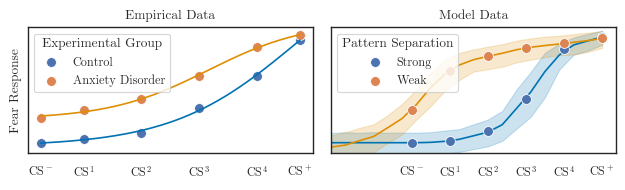

In [9]:
sparsities = [0.1, 0.2]
seeds = 10
nCS = 20
dim_CS = 3
dim_CTX = 5
nNeuronsExtCS = 3000
CSminusSim = 0.3
minSim = 0.0
# for i in sparsities:
#     print(f"sparsity {i}")
#     genCS(seeds=seeds, nCS=nCS, dim_CS=dim_CS, dim_CTX=dim_CTX, nNeuronsExtCS=nNeuronsExtCS,
#           sparsity=i, choose_intercepts_method='sparsity', nCond=15,
#           minSim=minSim, CSminusSim=CSminusSim, compare_empirical=True)
plot_genCS(sparsities, dim_CS, dim_CTX, xmin=minSim, ymin=0.35, ymax=1.1)

### Higher Dimensions

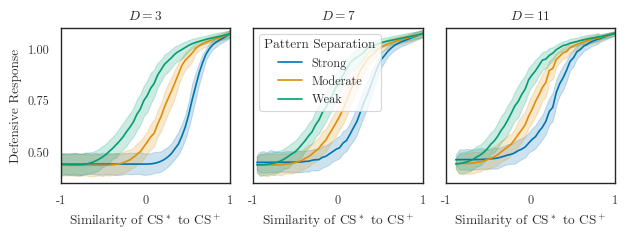

In [22]:
dimensions = [3, 7, 11]
sparsities = [0.15, 0.25, 0.35]
seeds = 20
nCS = 50
dim_CTX = 5
nNeuronsExtCS = 3000
CSminusSim = -1
minSim = -1
ymin, ymax = 0.35, 1.1
# for d in dimensions:
#     for i in sparsities:
#         print(f"dimension {d}, sparsity {i}")
#         genCS(seeds=seeds, nCS=nCS, dim_CS=d, dim_CTX=dim_CTX, nNeuronsExtCS=nNeuronsExtCS,
#               sparsity=i, choose_intercepts_method='sparsity',
#               minSim=minSim, CSminusSim=CSminusSim)

fig, axes = plt.subplots(nrows=1, ncols=len(dimensions), figsize=((6.38, 2.5)), sharey=True)
for j, dim_CS in enumerate(dimensions):
    for i, sparsity in enumerate(sparsities):
        data = pd.read_pickle(f"data/genCS_sparsity{sparsity}_dimCS={dim_CS}.pkl")
#         label = sparsity
        if sparsity==0.15: label="Strong"
        if sparsity==0.25: label="Moderate"
        if sparsity==0.35: label="Weak"
        sns.lineplot(data=data, x='Similarity to CS+', y="Fear Response",
            ax=axes[j], color=palette[i], label=label)
        axes[j].set(xticks=((-1.0, 0, 1.0)), xlim=((minSim, 1.0)),
            xlabel=r"Similarity of CS$^*$ to CS$^+$",
            title=r"$D=$"+str(dim_CS), ylabel="Defensive Response",
            yticks=((0.5, 0.75, 1.0)), ylim=((ymin, ymax)))
        axes[j].get_legend().remove()

# axes[0].legend(title="Sparsity")
axes[1].legend(title="Pattern Separation", loc='upper left')
# axes[2].legend(title="Pattern Separation", loc="center left", bbox_to_anchor=(1, 0.5))
plt.rc('axes', unicode_minus=False)
plt.tight_layout()
fig.savefig(f"plots/FigureN7.svg")
fig.savefig(f"plots/FigureN7.png", dpi=600)